In [28]:
import sys
sys.path.insert(0, '/home/sxh/Research/AttentiveFP/code',)

In [29]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="4"

In [30]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [31]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import itertools
from sklearn.metrics import r2_score
import scipy

In [32]:
seed = 77
np.random.seed(seed)
torch.manual_seed(8)

start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 2


number of all smiles:  3040
number of successfully processed smiles:  3040


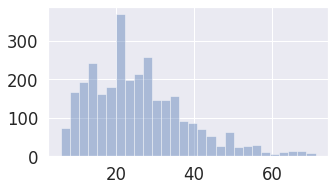

In [33]:
task_name = 'PDBbind-refined'
tasks = ['-logKd/Ki']

raw_filename = "/home/sxh/Research/AttentiveFP/data/pdb-refined.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

In [34]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

not processed items


,Unnamed: 0,smiles,-logKd/Ki,cano_smiles


In [39]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
   
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    try:
        valList = np.arange(0,dataset.shape[0])
        batch_list = []
        for i in range(0, dataset.shape[0], batch_size):
            batch = valList[i:i+batch_size]
            batch_list.append(batch) 
        for counter, test_batch in enumerate(batch_list):
            batch_df = dataset.loc[test_batch,:]
            smiles_list = batch_df.cano_smiles.values
    #         print(batch_df)
            y_val = batch_df[tasks[0]].values

            x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
            atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
            MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
            MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
    #         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)

            #test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
            test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    except:
        pass
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()



def predict(model, dataset):
    model.eval()
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
        
    preds = []
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        preds.append(mol_prediction.cpu().detach().numpy())


    return np.concatenate(preds,axis=0)

In [40]:
remained_df = remained_df.reset_index(drop=True)


'PDBbind-refined'

for seed in [2, 32, 128, 512, 1024]: 
    for fold in [0,1,2,3,4]: #
        
        df_train = pd.read_csv('./%s/seed_%s/fold_%s/train.csv' % (task_name, seed, fold))
        df_valid = pd.read_csv('./%s/seed_%s/fold_%s/valid.csv' % (task_name, seed, fold))
        df_test = pd.read_csv('./%s/seed_%s/fold_%s/test.csv' % (task_name, seed, fold))
        print(seed, fold)
        pred = './%s/seed_%s/fold_%s/pred_test.csv' % (task_name, seed, fold)
        if os.path.exists(pred):
            continue
            
        train_df = remained_df[remained_df.smiles.isin(df_train.smiles)].reset_index(drop=True)
        valid_df = remained_df[remained_df.smiles.isin(df_valid.smiles)].reset_index(drop=True)
        test_df = remained_df[remained_df.smiles.isin(df_test.smiles)].reset_index(drop=True)


        print(len(train_df),len(valid_df),len(test_df),)

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
        num_atom_features = x_atom.shape[-1]
        num_bond_features = x_bonds.shape[-1]
        loss_function = nn.MSELoss()
        model = Fingerprint(radius, T, num_atom_features, num_bond_features,
                    fingerprint_dim, output_units_num, p_dropout)
        model.cuda()

        optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

        best_param ={}
        best_param["train_epoch"] = 0
        best_param["valid_epoch"] = 0
        best_param["train_MSE"] = 9e8
        best_param["valid_MSE"] = 9e8

        for epoch in range(800):
            train_MAE, train_MSE = eval(model, train_df)
            valid_MAE, valid_MSE = eval(model, valid_df)
            if train_MSE < best_param["train_MSE"]:
                best_param["train_epoch"] = epoch
                best_param["train_MSE"] = train_MSE
            if valid_MSE < best_param["valid_MSE"]:
                best_param["valid_epoch"] = epoch
                best_param["valid_MSE"] = valid_MSE
                if valid_MSE < 0.6:
                     torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
            if (epoch - best_param["valid_epoch"]) > 18:        
                break
            print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))

            train(model, train_df, optimizer, loss_function)

        # evaluate model
        best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

        best_model_dict = best_model.state_dict()
        best_model_wts = copy.deepcopy(best_model_dict)

        model.load_state_dict(best_model_wts)
        (best_model.align[0].weight == model.align[0].weight).all()
        _, valid_MSE = eval(model, valid_df)
        print("best epoch:",best_param["valid_epoch"],"\n","valid RMSE:",np.sqrt(valid_MSE))


        pred_test = predict(model, test_df)
        pd.DataFrame(pred_test, index = test_df['smiles'],
                     columns = [task_name]).to_csv('./%s/seed_%s/fold_%s/pred_test.csv' % (task_name, seed, fold))

        pd.DataFrame(test_df[tasks].values, index = test_df['smiles'],
                     columns = [task_name]).to_csv('./%s/seed_%s/fold_%s/test.csv' % (task_name, seed, fold))

        pred_valid = predict(model, valid_df)
        pd.DataFrame(pred_valid, index = valid_df['smiles'], 
                     columns = [task_name]).to_csv('./%s/seed_%s/fold_%s/pred_valid.csv' % (task_name, seed, fold))

        pd.DataFrame(valid_df[tasks].values, index = valid_df['smiles'],
                     columns = [task_name]).to_csv('./%s/seed_%s/fold_%s/valid.csv' % (task_name, seed, fold))

2 0
2 1
2 2
2 3
2 4
32 0
32 1
32 2
32 3
32 4
2401 417 930


/home/sxh/anaconda3/envs/rdkit2020/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice.
/home/sxh/anaconda3/envs/rdkit2020/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 0.9967108 0.99539834
1 0.9898835 0.96385115
2 0.9843259 0.9681037
3 0.93066263 0.93128526
4 1.0076386 0.9942733
5 0.9220636 0.92416716
6 0.9171085 0.9482947
7 0.9076364 0.95181555
8 0.8896159 0.8999175
9 0.8675332 0.9111422
10 0.8538597 0.8811824
11 0.84601116 0.8689836
12 0.83590114 0.8702257
13 0.8930882 0.8968672
14 0.8474626 0.86912066
15 0.8387395 0.8567339
16 0.8871005 0.92469674
17 0.8888851 0.9100474
18 0.90144134 0.9477012
19 0.8825007 0.9291011
20 0.8761101 0.87301505
21 0.85114324 0.8847311
22 0.8547971 0.87100846
23 0.90362346 0.9526595
24 0.85163856 0.8772303
25 0.82822394 0.84446234
26 0.82944065 0.8377609
27 0.82706016 0.85727787
28 0.8458681 0.84368503
29 0.81532323 0.82860655
30 0.83815885 0.85811883
31 0.82972795 0.8291062
32 0.8300537 0.8430509
33 0.8448733 0.8506448
34 0.8603322 0.8594989
35 0.87840784 0.8833075
36 0.8528954 0.85621977
37 0.84873354 0.87874186
38 0.8711679 0.9016266
39 0.8785522 0.8744631
40 0.8638775 0.8981824
41 0.8656128 0.87503797
42 0.866046 

RuntimeError: Unknown error -1

In [ ]:
train_df